In [1]:
library(tidyverse)
library(xtable)
library(ggplot2)
library(ggpubr)
library(ggrepel)
library(gridExtra)
library(rstatix)
library(survival)
library(survminer)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter



Attaching package: ‘survminer’


The following object is masked from ‘package:survival’:

    myeloma




In [2]:
surveys1 <- read_csv("Datasets/effec1.quest.compil.csv", locale = locale("fr"), show_col_types = FALSE)
surveys2 <- read_csv("Datasets/effec2.quest.compil.csv", locale = locale("fr"), show_col_types = FALSE)
surveys3 <- read_csv("Datasets/effec3.quest.compil.csv", locale = locale("fr"), show_col_types = FALSE)
usages1 <- distinct(read_csv("Datasets/usages.effec1.csv", locale = locale("fr"), show_col_types = FALSE))
usages2 <- distinct(read_csv("Datasets/usages.effec2.csv", locale = locale("fr"), show_col_types = FALSE))
usages3 <- distinct(read_csv("Datasets/usages.effec3.csv", locale = locale("fr"), show_col_types = FALSE))

In [3]:
# Fix Exam.bin on usages1
usages1 <- usages1 %>% mutate(Exam.bin = case_when(last.quizz == 5 & last.video > 30 ~ 1,
                                                   TRUE ~ 0))

usages1 <- usages1 %>% 
           mutate(EngagementLevel = case_when(Exam.bin == 1 & Assignment.bin == 1 ~ 3, # Completers
                                              last.quizz > 0 | Assignment.bin == 1 ~ 2, # Disengaging Learners
                                              last.video / 35 > 0.1 ~ 1, # Auditing Learners
                                              TRUE ~ 0)) # Bystanders

usages2 <- usages2 %>%
           mutate(EngagementLevel = case_when(Exam.bin == 1 & Assignment.bin == 1 ~ 3, # Completers
                                              last.quizz > 0 | Assignment.bin == 1 ~ 2, # Disengaging Learners
                                              last.video / 35 > 0.1 ~ 1, # Auditing Learners
                                              TRUE ~ 0)) # Bystanders

usages3 <- usages3 %>%
           mutate(EngagementLevel = case_when(Exam.bin == 1 & Assignment.bin == 1 ~ 3, # Completers
                                              last.quizz > 0 | Assignment.bin == 1 ~ 2, # Disengaging Learners
                                              last.video / 35 > 0.1 ~ 1, # Auditing Learners
                                              TRUE ~ 0)) # Bystanders

Saving 7 x 7 in image



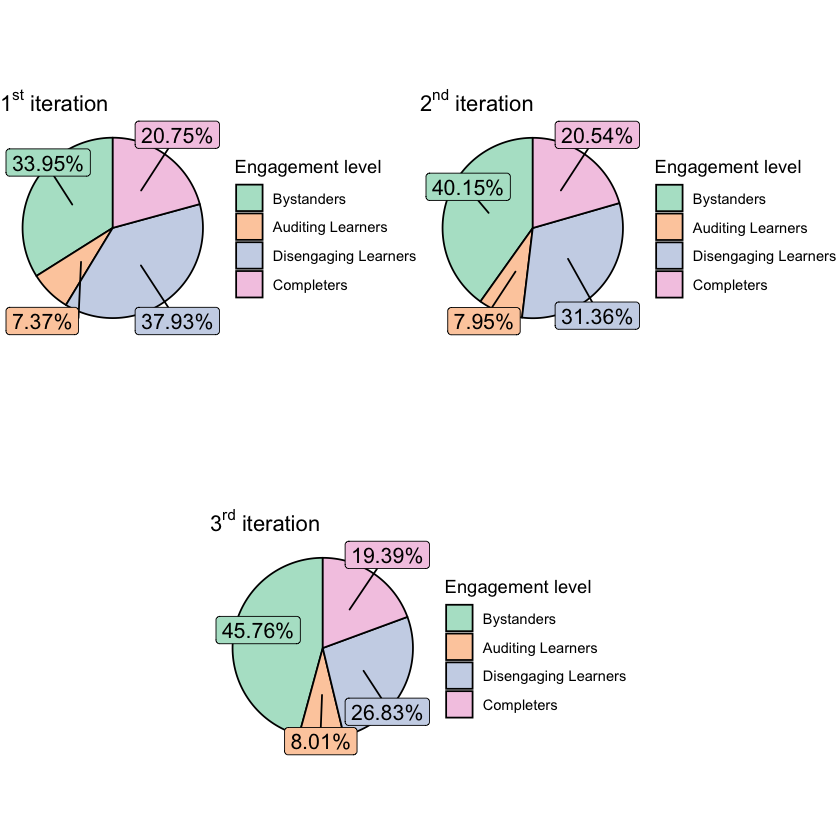

In [4]:
df1 <- usages1 %>% group_by(EngagementLevel) %>% tally(name = "value") %>%
          mutate(csum = rev(cumsum(rev(value))), 
         pos = if_else(is.na(value/2 + lead(csum, 1)), value/2, value/2 + lead(csum, 1)))

plot1 <- ggplot(df1, aes(x = "" , y = value, fill = factor(EngagementLevel))) +
  geom_col(width = 1, color = 1) +
  coord_polar(theta = "y") +
  geom_label_repel(data = df1,
                   aes(y = pos, label = paste0(round(value / sum(value) * 100,
                                              digits = 2), "%")),
                   size = 4.5, nudge_x = 1, show.legend = FALSE) +
  scale_fill_brewer(palette = "Pastel2", name = "Engagement level",
                    labels = c('Bystanders', 'Auditing Learners',
                    'Disengaging Learners', 'Completers')) +
  
  theme_void() + labs(title = expression('1'^st*' iteration'))

df2 <- usages2 %>% group_by(EngagementLevel) %>% tally(name = "value") %>%
          mutate(csum = rev(cumsum(rev(value))), 
         pos = if_else(is.na(value/2 + lead(csum, 1)), value/2, value/2 + lead(csum, 1)))

plot2 <- ggplot(df2, aes(x = "" , y = value, fill = factor(EngagementLevel))) +
  geom_col(width = 1, color = 1) +
  coord_polar(theta = "y") +
  geom_label_repel(data = df2,
                   aes(y = pos, label = paste0(round(value / sum(value) * 100,
                                              digits = 2), "%")),
                   size = 4.5, nudge_x = 1, show.legend = FALSE) +
  scale_fill_brewer(palette = "Pastel2", name = "Engagement level",
                    labels = c('Bystanders', 'Auditing Learners',
                    'Disengaging Learners', 'Completers')) +
  
  theme_void() + labs(title = expression('2'^nd*' iteration'))

df3 <- usages3 %>% group_by(EngagementLevel) %>% tally(name = "value") %>%
          mutate(csum = rev(cumsum(rev(value))), 
         pos = if_else(is.na(value/2 + lead(csum, 1)), value/2, value/2 + lead(csum, 1)))

plot3 <- ggplot(df3, aes(x = "" , y = value, fill = factor(EngagementLevel))) +
  geom_col(width = 1, color = 1) +
  coord_polar(theta = "y") +
  geom_label_repel(data = df3,
                   aes(y = pos, label = paste0(round(value / sum(value) * 100,
                                              digits = 2), "%")),
                   size = 4.5, nudge_x = 1, show.legend = FALSE) +
  scale_fill_brewer(palette = "Pastel2", name = "Engagement level",
                    labels = c('Bystanders', 'Auditing Learners',
                    'Disengaging Learners', 'Completers')) +
  
  theme_void() + labs(title = expression('3'^rd*' iteration'))

g <- arrangeGrob(plot1, plot2, plot3, ncol = 2, layout_matrix=rbind(c(1,1,2,2), c(NA, 3, 3, NA)))
ggsave("Plots/engagement_level.png", g)
grid.arrange(plot1, plot2, plot3, ncol = 2, layout_matrix=rbind(c(1,1,2,2), c(NA, 3, 3, NA)))

# Linear Model

Prepare data to apply linear models

In [5]:
# Merge data
iter1 <- distinct(left_join(surveys1, usages1, by='Student_ID'))
iter2 <- distinct(left_join(surveys2, usages2, by='Student_ID'))
iter3 <- distinct(left_join(surveys3, usages3, by='Student_ID'))
iter3 <- iter3 %>% mutate_at(c('Curiosity.MOOC', 'Rencontres'), as.numeric)
df <- iter1 %>% full_join(iter2) %>% full_join(iter3)

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Joining, by = c("Student_ID", "Gender", "birth.year", "Country", "Diploma", "Formation", "CSP", "How.heard", "Exp.crea", "Curiosity.MOOC", "Certif.self.sat", "Rencontres", "Certif.work", "Incitation", "Temps.Dispo", "Exp.MOOC", "Completion.proba", "Instit.brand", "motiv.princ", "diffic", "encad.disp", "How.contact", "entour", "entour.inter", "Satisf", "Eval.diffic", "Estimated.hours", "Part.labo", "Plat.satisf", "Peer.eval.relev", "Country_HDI", "Country_HDI.fin", "CSP.fin", "Temps.dispo.fin", "Exam.score", "Exam.bin", "Assignment.score", "Assignment.bin", "Quizz.1.score", "Quizz.1.bin", "Quizz.2.score", "Quizz.2.bin", "Quizz.3.score", "Quizz.3.bin", "Quizz.4.bin", "Quizz.4.score", "Quizz.5.bin", "Quizz.5.score", "Intro.MOOC", "Prez.sem.1", "S1.L1", "S1.L2", "S1.L3", "S1.L4", "S1.L5", "S1.L6", "Prez.sem.2", "S2.L1", "S2.L2", "S2.L3", "S2.

In [6]:
df <- df %>% mutate(Country_HDI = case_when(Country_HDI == "TH" ~ "Very High",
                                            Country_HDI == "H" | Country_HDI == "M" ~ "Intermetidate",
                                            Country_HDI == "B" ~ "Low"))
df$Country_HDI <- factor(df$Country_HDI, levels = c("Very High", "Intermetidate", "Low"))

df <- df %>% mutate(Gender = case_when(Gender == "un homme" ~ "Male",
                                       Gender == "une femme" ~"Female"))
df$Gender <- factor(df$Gender, levels = c("Male", "Female"))

## From Student’s t-test to two-ways ANOVAs

Gender and Viewed videos

In [7]:
df.t_test <- df %>% drop_na(c(Gender, last.video))
df.t_test %>%
  group_by(Gender) %>%
  get_summary_stats(last.video, type = "mean_sd")

Gender,variable,n,mean,sd
<fct>,<chr>,<dbl>,<dbl>,<dbl>
Male,last.video,6103,20.843,13.458
Female,last.video,2990,20.773,13.912


In [8]:
# Independent sample t-test
stat.test <- df.t_test %>% 
             t_test(last.video ~ Gender, detailed = TRUE) %>%
             add_significance()
stat.test

,estimate,estimate1,estimate2,.y.,group1,group2,n1,n2,statistic,p,df,conf.low,conf.high,method,alternative,p.signif
,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,0.07044603,20.84336,20.77291,last.video,Male,Female,6103,2990,0.2292759,0.819,5764.39,-0.5318881,0.6727801,T-test,two.sided,ns


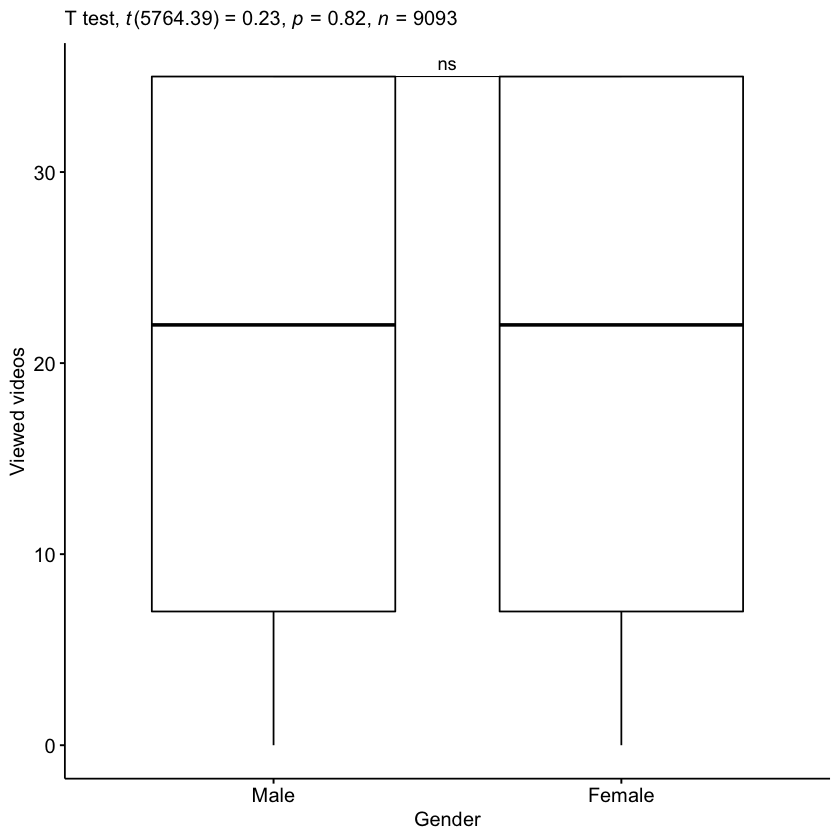

In [9]:
# Create a box-plot
bxp <- ggboxplot(
  df.t_test, x = "Gender", y = "last.video", 
  ylab = "Viewed videos", xlab = "Gender")

# Add p-value and significance levels
stat.test <- stat.test %>% add_xy_position(x = "Gender")
bxp + 
  stat_pvalue_manual(stat.test, tip.length = 0) +
  labs(subtitle = get_test_label(stat.test, detailed = TRUE))

Country's HDI and Viewed videos

In [10]:
df.anova <- df %>% drop_na(c(Country_HDI, last.video))
df.anova %>%
  group_by(Country_HDI) %>%
  get_summary_stats(last.video, type = "mean_sd")

Country_HDI,variable,n,mean,sd
<fct>,<chr>,<dbl>,<dbl>,<dbl>
Very High,last.video,7264,21.665,13.580
Intermetidate,last.video,667,18.099,13.846
Low,last.video,1032,16.633,12.638


In [11]:
# Levene test
levene <- df.anova %>% levene_test(last.video ~ Country_HDI)
levene

df1,df2,statistic,p
<int>,<int>,<dbl>,<dbl>
2,8960,11.85427,7.220328e-06


In [12]:
# Welch One way ANOVA test
res.aov <- df.anova %>% welch_anova_test(last.video ~ Country_HDI)
res.aov

,.y.,n,statistic,DFn,DFd,p,method
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,last.video,8963,83.45,2,1310.252,7.7e-35,Welch ANOVA


In [13]:
# Pairwise comparisons (Games-Howell)
pwc <- df.anova %>% games_howell_test(last.video ~ Country_HDI)
pwc

,.y.,group1,group2,estimate,conf.low,conf.high,p.adj,p.adj.signif
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,last.video,Very High,Intermetidate,-3.566385,-4.879709,-2.25306145,0.000,****
2,last.video,Very High,Low,-5.032584,-6.028394,-4.03677382,0.000,****
3,last.video,Intermetidate,Low,-1.466199,-3.026445,0.09404754,0.071,ns


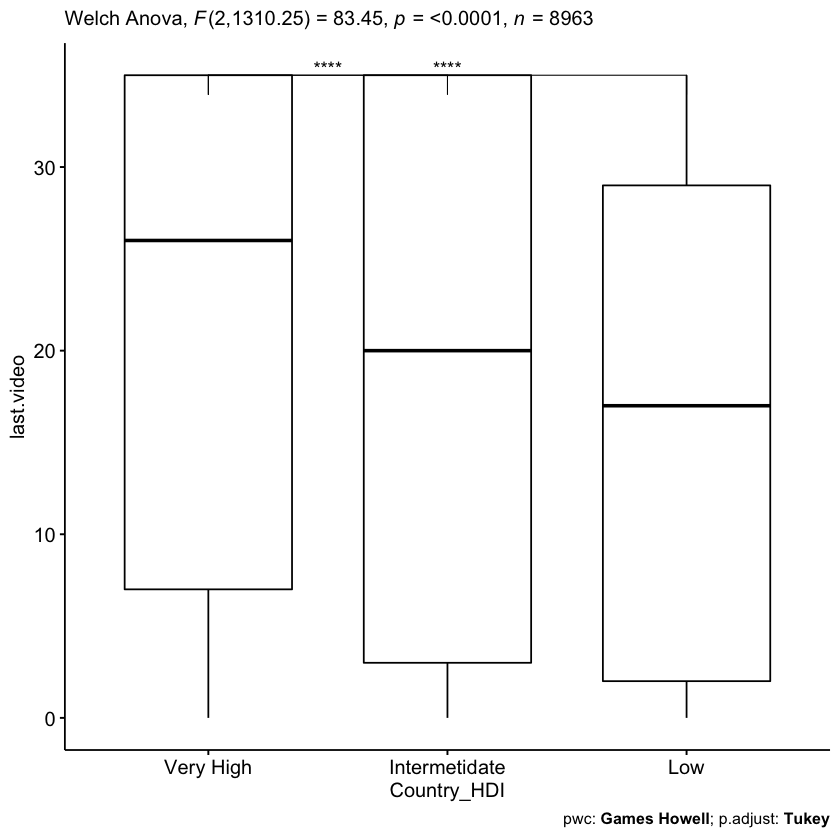

In [19]:
# Visualization: box plots with p-values
pwc <- pwc %>% add_xy_position(x = "Country_HDI")
ggboxplot(df.anova, x = "Country_HDI", y = "last.video") +
  stat_pvalue_manual(pwc, hide.ns = TRUE) +
  labs(
    subtitle = get_test_label(res.aov, detailed = TRUE),
    caption = get_pwc_label(pwc)
    )

## Model reﬁnement, pairwise comparisons

# Logistic Regression

## Producing an Odd-Ratios table

## Poisson models for count data

# Survival Analysis

Prepare data to apply linear models

In [15]:
df <- df %>% mutate(status = case_when(last.video < 30 ~ 1,
                                           TRUE ~ 0))

df <- df %>% mutate(Group = case_when(EngagementLevel == 1 ~ "Auditing",
                                      EngagementLevel == 2 ~ "Disengaging"))
df$Group <- factor(df$Group, levels = c("Disengaging","Auditing"))

Call:
coxph(formula = Surv(last.video, status) ~ Country_HDI, data = df)

                            coef exp(coef) se(coef)      z       p
Country_HDIIntermetidate 0.33867   1.40308  0.04950  6.842 7.8e-12
Country_HDILow           0.56331   1.75648  0.03808 14.791 < 2e-16

Likelihood ratio test=219.5  on 2 df, p=< 2.2e-16
n= 8963, number of events= 5349 
   (7957 observations deleted due to missingness)

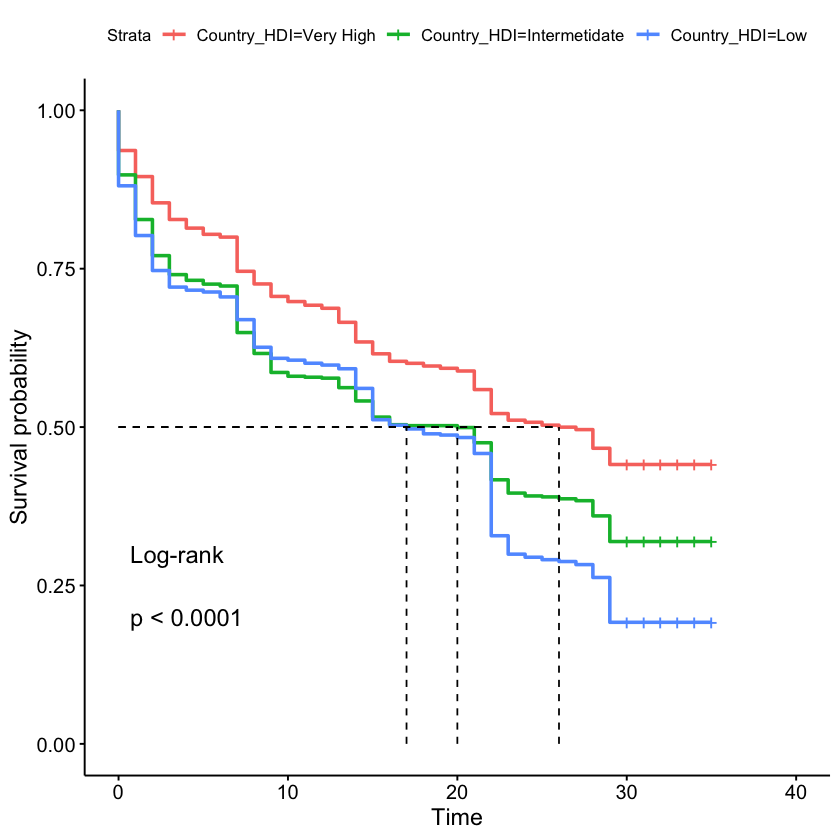

In [16]:
# Reference: Very High
coxph(formula = Surv(last.video, status) ~ Country_HDI, data = df)
survival_HDI <- survfit(Surv(last.video, status) ~ Country_HDI, data = df)
ggsurvplot(
  survival_HDI,
  conf.int = FALSE,
  surv.median.line = c('hv'), 
  data = df, 
  pval = TRUE,
  pval.method = TRUE,
  risk.table = FALSE)

Call:
coxph(formula = Surv(last.video, status) ~ Group, data = df)

                 coef exp(coef) se(coef)     z      p
GroupAuditing 0.78863   2.20038  0.03464 22.77 <2e-16

Likelihood ratio test=446.6  on 1 df, p=< 2.2e-16
n= 6252, number of events= 5294 
   (10668 observations deleted due to missingness)

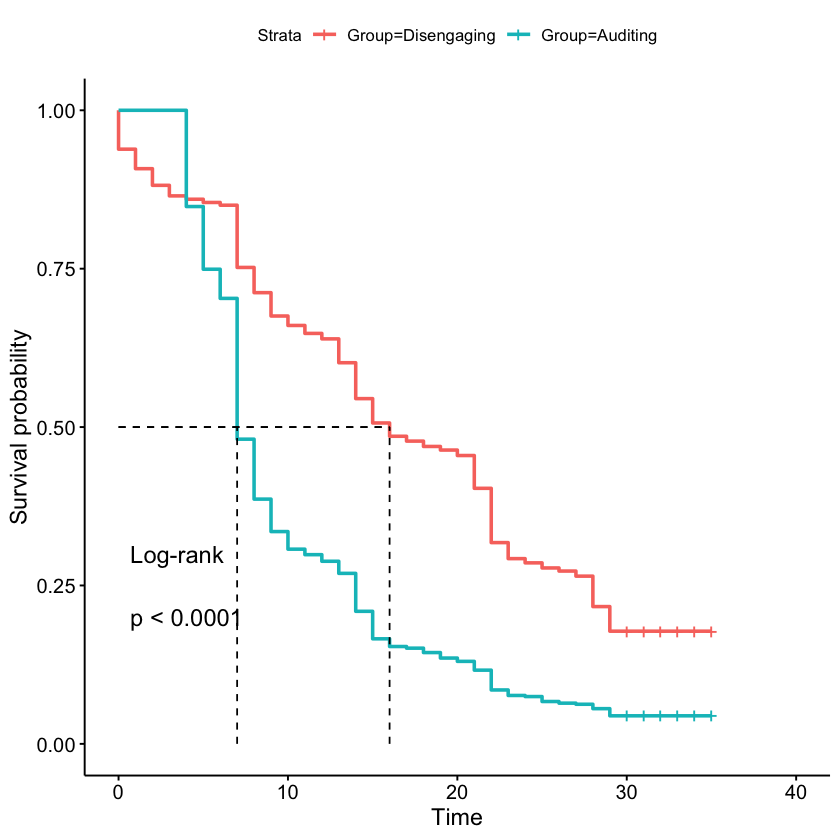

In [17]:
# Reference: Disengaging
coxph(formula = Surv(last.video, status) ~ Group, data = df)
survival_Group <- survfit(Surv(last.video, status) ~ Group, data = df)
ggsurvplot(
  survival_Group,
  conf.int = FALSE,
  surv.median.line = c('hv'),
  data = df, 
  pval = TRUE,
  pval.method = TRUE,
  risk.table = FALSE)